In [50]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [51]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [52]:
Base = automap_base()

In [53]:

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [54]:
Base.classes.keys()


['measurements', 'station']

In [55]:
inspector = inspect(engine)

inspector.get_table_names()

['measurements', 'station']

In [56]:

# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurements LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65),
 (2, 'USC00519397', '2010-01-02', 0.0, 63),
 (3, 'USC00519397', '2010-01-03', 0.0, 74),
 (4, 'USC00519397', '2010-01-04', 0.0, 76),
 (5, 'USC00519397', '2010-01-06', 0.0, 73),
 (6, 'USC00519397', '2010-01-07', 0.06, 70),
 (7, 'USC00519397', '2010-01-08', 0.0, 64),
 (8, 'USC00519397', '2010-01-09', 0.0, 68),
 (9, 'USC00519397', '2010-01-10', 0.0, 73),
 (10, 'USC00519397', '2010-01-11', 0.01, 64)]

In [57]:
Station = Base.classes.station
Measurements = Base.classes.measurements

In [58]:
session = Session(engine)

In [59]:
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [60]:
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [61]:
rain = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date > last_year).order_by(Measurements.date).all()

In [62]:
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,0.00
4,2016-08-24,1.22


In [63]:
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22


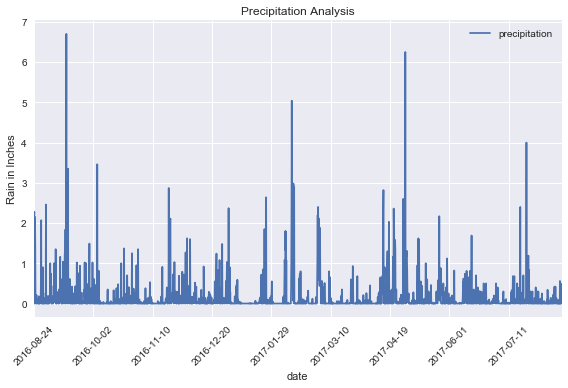

In [64]:
rain_df.plot('date', 'prcp')
plt.xlabel("date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis")
plt.legend(["precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
rain_df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [66]:
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [67]:

# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [68]:

# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

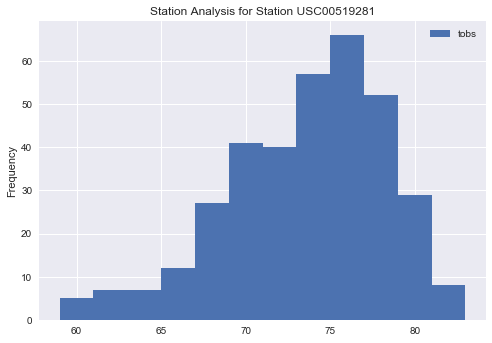

In [69]:
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.ylabel("Frequency")
plt.title("Station Analysis for Station " + busiest)
plt.legend(["tobs"])
plt.show()

In [70]:
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)

[(62, 69.57142857142857, 74)]


In [71]:
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67, 74.47368421052632, 82)]


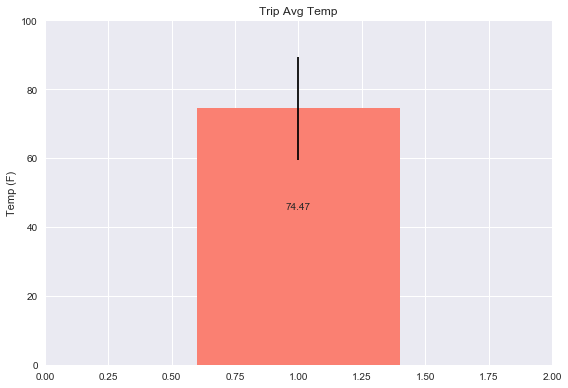

In [72]:
p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'salmon', yerr=p2p)
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")

autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()